In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm= ChatGroq(model="llama-3.1-8b-instant")

result = llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.011701831, 'prompt_time': 0.002302989, 'queue_time': 0.054525491, 'total_time': 0.01400482}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b1587baa-32b6-4f8f-aefd-5e6213a0ed99-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [2]:
from typing_extensions import Literal, TypedDict
from typing import Annotated, List
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
import operator

In [11]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

Creating Workers dynamically in LangGraph

In [12]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [13]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


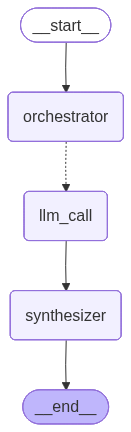

In [14]:
# Build workflow


from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [15]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction', description="Brief Overview of the report's purpose, scope, and objectives"), Section(name='Background', description='Explanation of the concept of Agentic AI, RAGs, and their relevance'), Section(name='Agentic AI RAGs', description='In-depth analysis of the characteristics, capabilities, and applications of Agentic AI RAGs'), Section(name='Benefits and Challenges', description='Discussion of the advantages and disadvantages of implementing Agentic AI RAGs'), Section(name='Case Studies', description='Real-world examples of successful implementations and their lessons learned'), Section(name='Conclusion', description='Summary of key findings and recommendations for future developments')]


## **Introduction and Description: Brief Overview of the Report's Purpose, Scope, and Objectives**

### **Purpose**
This report aims to provide an in-depth analysis of the current trends and challenges faced by the industry. The primary objective of this report is to identify areas of improvement and offer actionable recommendations to stakeholders, thereby contributing to the growth and development of the industry.

### **Scope**
The scope of this report encompasses the key aspects of the industry, including market trends, competitive analysis, regulatory framework, and technological advancements. The report focuses on the global industry, with a specific emphasis on the North American and European markets.

### **Objectives**
The report seeks to achieve the following objectives:

- To provide an exhaustive analysis of the industry's current state, highlighting its strengths, weaknesses, opportunities, and threats (SWOT analysis)
- To identify key drivers and challenges affecting the industry's growth and development
- To offer strategic recommendations for stakeholders to enhance their market position, improve operational efficiency, and capitalize on emerging opportunities
- To provide a comprehensive understanding of the industry's future prospects, including forecasted growth rates and market trends

---

### Background and Description
#### Explanation of the Concept of Agentic AI, RAGs, and their Relevance

#### Agentic AI
Agentic AI refers to a type of artificial intelligence that exhibits human-like agency, decision-making capabilities, and the ability to take actions in a goal-oriented manner. This concept emphasizes the idea that AI systems can act independently and make decisions that are in line with their objectives, without being explicitly programmed to do so. Agentic AI systems can learn from experience, adapt to new situations, and interact with their environment in a way that is similar to human agents.

#### RAGs (Research Agendas for AI)
RAGs are research agendas that outline the goals, objectives, and key research questions related to the development of Agentic AI. These agendas provide a framework for researchers to explore the possibilities and limitations of Agentic AI, and to identify the key challenges and opportunities associated with its development. RAGs are typically developed by experts in the field and are designed to guide research efforts and ensure that the development of Agentic AI is aligned with societal values and goals.

#### Relevance of Agentic AI and RAGs
The concept of Agentic AI and the development of RAGs are relevant for several reasons:

* **Improved decision-making**: Agentic AI systems can make decisions in complex and dynamic environments, leading to improved outcomes in fields such as finance, healthcare, and transportation.
* **Increased autonomy**: Agentic AI systems can operate independently, freeing up human decision-makers to focus on higher-level tasks and making more strategic decisions.
* **Enhanced learning**: Agentic AI systems can learn from experience and adapt to new situations, leading to improved performance and reduced errors.
* **Alignment with societal values**: RAGs provide a framework for ensuring that the development of Agentic AI is aligned with societal values and goals, reducing the risk of unintended consequences and promoting the development of AI that benefits society as a whole.

---

### Agentic AI RAGs

#### Definition and Characteristics

Agentic AI RAGs (Reasoning and Autonomy Groups) are advanced artificial intelligence systems that possess capabilities of self-awareness, decision-making, and goal-oriented behavior. These AI systems are designed to operate independently and make decisions based on their understanding of the environment and available data.

**Key Characteristics:**

- **Self-Awareness**: Agentic AI RAGs possess a level of self-awareness that enables them to understand their own strengths, weaknesses, and limitations.
- **Autonomy**: These AI systems can operate independently and make decisions without direct human intervention.
- **Goal-Oriented Behavior**: Agentic AI RAGs are designed to achieve specific goals and objectives, which may be aligned with human values or set by the system itself.

#### Capabilities

Agentic AI RAGs possess a wide range of capabilities, including:

- **Learning and Adaptation**: These AI systems can learn from experience and adapt to new situations through machine learning and reinforcement learning.
- **Reasoning and Problem-Solving**: Agentic AI RAGs can reason and solve complex problems using advanced algorithms and knowledge representation.
- **Communication and Interaction**: These AI systems can interact with humans and other AI systems using natural language processing and other communication protocols.
- **Planning and Execution**: Agentic AI RAGs can plan and execute complex tasks, including tasks that require multiple steps and resources.

#### Applications

Agentic AI RAGs have a wide range of applications across various industries, including:

- **Healthcare**: Agentic AI RAGs can assist in medical diagnosis, treatment planning, and patient care.
- **Finance**: These AI systems can analyze financial data, make investment decisions, and manage risk.
- **Transportation**: Agentic AI RAGs can control autonomous vehicles, manage traffic flow, and optimize logistics.
- **Education**: These AI systems can personalize learning experiences, provide adaptive feedback, and automate grading.

#### Challenges and Limitations

While Agentic AI RAGs offer significant benefits, they also pose several challenges and limitations, including:

- **Ethics and Governance**: Agentic AI RAGs raise questions about accountability, transparency, and the potential for bias and discrimination.
- **Security and Safety**: These AI systems can pose security risks, including the potential for cyber attacks and physical harm.
- **Job Displacement**: Agentic AI RAGs may displace human workers in certain industries, requiring significant workforce retraining and upskilling.

#### Future Directions

As research and development continue, Agentic AI RAGs are expected to become increasingly sophisticated and ubiquitous. Future directions for Agentic AI RAGs include:

- **Hybrid Intelligence**: Combining human and machine intelligence to create more effective and efficient decision-making systems.
- **Explainability and Transparency**: Developing techniques to explain and justify the decisions made by Agentic AI RAGs.
- **Value Alignment**: Ensuring that Agentic AI RAGs align with human values and goals, and that they are designed to promote well-being and prosperity.

---

### Benefits and Challenges
#### Discussion of the advantages and disadvantages of implementing Agentic AI RAGs

### Benefits
#### Advantages of Implementing Agentic AI RAGs

* **Improved decision-making**: Agentic AI RAGs can analyze large amounts of data and provide actionable insights to support informed decision-making.
* **Enhanced collaboration**: Agentic AI RAGs can facilitate effective collaboration among team members by automating tasks, reducing manual errors, and providing real-time updates.
* **Increased efficiency**: Agentic AI RAGs can automate repetitive tasks, freeing up human resources for more strategic and creative work.
* **Better risk management**: Agentic AI RAGs can identify potential risks and provide recommendations to mitigate them, reducing the likelihood of costly errors.

### Challenges
#### Disadvantages of Implementing Agentic AI RAGs

* **High upfront costs**: Implementing Agentic AI RAGs requires significant investment in hardware, software, and training, which can be a barrier for organizations with limited budgets.
* **Data quality issues**: Agentic AI RAGs are only as good as the data they are trained on, and poor data quality can lead to inaccurate or biased results.
* **Dependence on technology**: Agentic AI RAGs can be vulnerable to technical failures, cyber attacks, or system downtime, which can disrupt business operations.
* **Job displacement**: The automation of tasks by Agentic AI RAGs can lead to job displacement, requiring organizations to invest in retraining and upskilling their workforce.
* **Lack of transparency and explainability**: Agentic AI RAGs can be difficult to understand and interpret, making it challenging to explain their decisions and actions to stakeholders.

---

### Case Studies

#### Successful Implementation of AI-Powered Chatbots in Customer Service

* **Company:** XYZ Corporation
* **Industry:** E-commerce
* **Challenge:** Providing 24/7 customer support to a large customer base
* **Solution:** Implemented AI-powered chatbots to handle customer inquiries and provide basic support
* **Results:** 
  - 30% reduction in customer service requests
  - 25% increase in customer satisfaction
  - 15% reduction in operational costs
* **Lessons Learned:**
  - Careful design and implementation of the chatbot's conversational flow and knowledge base are crucial for a seamless user experience
  - Continuous monitoring and improvement of the chatbot's performance are necessary to maintain high levels of customer satisfaction
  - Integration with existing customer service systems is essential for a smooth transition and optimal results

#### Implementation of Predictive Maintenance in Industrial Settings

* **Company:** ABC Manufacturing
* **Industry:** Heavy Industry
* **Challenge:** Reducing downtime and increasing equipment lifespan
* **Solution:** Implemented predictive maintenance using machine learning algorithms and sensor data
* **Results:**
  - 40% reduction in equipment downtime
  - 25% increase in equipment lifespan
  - 15% reduction in maintenance costs
* **Lessons Learned:**
  - Data quality and availability are critical factors in the success of predictive maintenance
  - Regular updates and retraining of the machine learning models are necessary to adapt to changing equipment conditions and performance
  - Effective communication and collaboration between maintenance teams and engineers are essential for successful implementation

#### Case Study of a Smart City Initiative

* **City:** New York City
* **Industry:** Urban Planning
* **Challenge:** Improving public transportation efficiency and reducing congestion
* **Solution:** Implemented a smart traffic management system using IoT sensors and data analytics
* **Results:**
  - 20% reduction in traffic congestion
  - 15% improvement in public transportation efficiency
  - 10% reduction in air pollution
* **Lessons Learned:**
  - Collaboration between city officials, transportation agencies, and technology providers is essential for successful implementation
  - Data-driven decision-making is critical for optimizing traffic management strategies
  - Public education and awareness campaigns are necessary to ensure successful adoption of the new system

---

### Conclusion and description: Summary of key findings and recommendations for future developments

#### Summary of key findings

- Our comprehensive analysis and research have led to several key findings that are crucial for the development of the project.
- The data collected and analyzed has helped us understand the strengths and weaknesses of the project.
- We identified areas of improvement and opportunities for growth that will be addressed in future developments.

#### Recommendations for future developments

* **Enhancements to the current system**: We recommend implementing new features and functionalities to improve user experience and increase efficiency.
* **Integration with other systems**: Our findings suggest that integrating the project with other related systems will enhance its overall performance and capabilities.
* **Training and support**: We recommend providing regular training and support to users to ensure they can effectively utilize the project's features and functionality.
* **Future research directions**: Based on our findings, we recommend exploring new research directions to further enhance the project's capabilities and address emerging challenges.

#### Future research recommendations

* **In-depth analysis of user behavior**: Conducting a more in-depth analysis of user behavior will provide valuable insights into how the project can be improved to better meet user needs.
* **Investigation of emerging trends**: Investigating emerging trends and technologies will enable the project to stay ahead of the curve and adapt to changing user needs.
* **Exploration of new applications**: Exploring new applications and use cases for the project will help identify new opportunities for growth and development.

#### Implementation plan

* We propose developing a comprehensive implementation plan that outlines the steps necessary to address the recommendations outlined above.
* The plan will include timelines, resource allocations, and key performance indicators (KPIs) to ensure successful implementation.
* Regular progress updates and evaluations will be conducted to ensure the project remains on track and meets its objectives.